### Sentiment Analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import re
import pickle

In [2]:
data = pd.read_csv('airline_sentiment_analysis.csv', index_col=0)
data.head(10)

,airline_sentiment,text
1,positive,@VirginAmerica plus you've added commercials t...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...
5,negative,@VirginAmerica seriously would pay $30 a fligh...
6,positive,"@VirginAmerica yes, nearly every time I fly VX..."
8,positive,"@virginamerica Well, I didn't…but NOW I DO! :-D"
9,positive,"@VirginAmerica it was amazing, and arrived an ..."
11,positive,@VirginAmerica I &lt;3 pretty graphics. so muc...
12,positive,@VirginAmerica This is such a great deal! Alre...
13,positive,@VirginAmerica @virginmedia I'm flying your #f...


In [3]:
data['airline_sentiment'].value_counts()

negative    9178
positive    2363
Name: airline_sentiment, dtype: int64

In [4]:
data.isnull().sum()

airline_sentiment    0
text                 0
dtype: int64

In [5]:
import nltk
import string
from nltk.corpus import wordnet
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize

pos_tags = {"J": wordnet.ADJ, "N": wordnet.NOUN, 
                "V": wordnet.VERB, "R": wordnet.ADV}

class Preprocessing:
        
    def __init__(self):
        super(Preprocessing, self).__init__()

    @staticmethod
    def load_data(config):
        """
        Loading data from CSV file
        """
        data = pd.read_csv(config.data_path)
        if 'Unnamed: 0'in data.columns:
            data = data.drop(['Unnamed: 0'], axis=1)
        return data

    @staticmethod
    def index_to_label(index):
        """
        converting 1 sentiment to positive and 0 sentiment to negative 
        """
        return 'positive' if index == 1 else 'negative'

    @staticmethod
    def label_to_index(label):
        """
        converting positive sentiment to 1 and negative sentiment to 0 
        """
        return 1 if label == 'positive' else 0

    @staticmethod
    def clean_text(text_string) -> str:
        """
        converting text to lowercase 
        removing all hashtags, stop_words, extra space, digits
        """
        process_text = text_string.lower()  # Convert string to lower
        process_text = re.sub(r"(@\S+)", "", process_text)  # Remove hashtags
        process_text = re.sub("<.*?>", " ", process_text) 
        process_text = ''.join([i for i in process_text if not i.isdigit()]).strip()  # Removing all digits only
        process_text = process_text.split(" ")  
        process_text = " ".join([word for word in process_text if word not in stopwords.words("english")]) # Removing all stop words
        process_text = " ".join(process_text.split())  # Removing extra spaces via splitting and joining
        return process_text

    @staticmethod
    def lemmatizing(text):
        """
        removing punctuations and lemmatizing text
        """
        tokens = []
        lemmatizer = WordNetLemmatizer()
        unigrams = word_tokenize(text) # input text to unigrams
        for word in unigrams:
            pos_tag = nltk.pos_tag([word])[0][1][0].upper()
            word = lemmatizer.lemmatize(word, pos_tags.get(pos_tag, wordnet.NOUN)) # Lemmatizing all unigrams
            # removing all punctuations, empty unigrams
            if word not in string.punctuation and re.match(r'[\w+]', word):
                tokens.append(word)
        process_text = " ".join(tokens)      
        return process_text
    
class app_config():
    data_path = 'airline_sentiment_analysis.csv'
    val_size = 0.2
    random_state = 42
    max_pad_len = 25
    token_path = 'token.pickle'

    validation_split=0.0
    epochs=50
    batch_size=64
    model_path = "BiLSTM_Model"

    # Model Parameters
    embedding_dim = 11058
    output_dim = 64
    learning_rate=0.001

In [6]:
preprocessing = Preprocessing()
data = preprocessing.load_data(app_config)
data['airline_sentiment'] = data['airline_sentiment'].apply(preprocessing.label_to_index)
data.head(10)

,airline_sentiment,text
0,1,@VirginAmerica plus you've added commercials t...
1,0,@VirginAmerica it's really aggressive to blast...
2,0,@VirginAmerica and it's a really big bad thing...
3,0,@VirginAmerica seriously would pay $30 a fligh...
4,1,"@VirginAmerica yes, nearly every time I fly VX..."
5,1,"@virginamerica Well, I didn't…but NOW I DO! :-D"
6,1,"@VirginAmerica it was amazing, and arrived an ..."
7,1,@VirginAmerica I &lt;3 pretty graphics. so muc...
8,1,@VirginAmerica This is such a great deal! Alre...
9,1,@VirginAmerica @virginmedia I'm flying your #f...


In [7]:
data['text'] = data['text'].apply(preprocessing.clean_text)
data.head(10)

,airline_sentiment,text
0,1,plus added commercials experience... tacky.
1,0,"really aggressive blast obnoxious ""entertainme..."
2,0,really big bad thing
3,0,seriously would pay $ flight seats playing. it...
4,1,"yes, nearly every time fly vx “ear worm” won’t..."
5,1,"well, didn't…but do! :-d"
6,1,"amazing, arrived hour early. good me."
7,1,&lt; pretty graphics. much better minimal icon...
8,1,great deal! already thinking nd trip &amp; eve...
9,1,i'm flying #fabulous #seductive skies again! u...


In [8]:
data['text'] = data['text'].apply(preprocessing.lemmatizing)
data.head(10)

,airline_sentiment,text
0,1,plus add commercial experience tacky
1,0,really aggressive blast obnoxious entertainmen...
2,0,really big bad thing
3,0,seriously would pay flight seat play it really...
4,1,yes nearly every time fly vx ear worm won t go...
5,1,well didn't…but do
6,1,amaze arrive hour early good me
7,1,lt pretty graphic much well minimal iconography d
8,1,great deal already think nd trip amp even go s...
9,1,i fly fabulous seductive sky again u take stre...


### CountVectorizer and Train-Test Split for Logistic Regression, RandomForestClassifier

In [9]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

def train_test_data(X, y):   
    text_train, text_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=0)    # do the split
    vectorizer = CountVectorizer(min_df=5, ngram_range=(1, 4))
    X_train = vectorizer.fit_transform(text_train)
    X_test = vectorizer.transform(text_test) 
    
    return X_train, X_test, y_train, y_test, vectorizer

In [10]:
 X_train, X_test, y_train, y_test, vectorizer = train_test_data(data['text'], data['airline_sentiment'])

### Logistic Regression

In [11]:
# LogisticRegression 
from sklearn.linear_model import LogisticRegression

class LRegression:
    def logistic_regression(self):
        lr_model = LogisticRegression(penalty='l2',solver='sag', max_iter=1000)
        lr_model.fit(X_train, y_train)
        lr_prediction = lr_model.predict(X_test)
        return lr_prediction
    
lr_prediction = LRegression().logistic_regression()

In [12]:
from sklearn import metrics
from sklearn.metrics import f1_score,precision_score,recall_score
from sklearn.metrics import precision_recall_fscore_support as score
print("Accuracy of the Logistic Regression is:", metrics.accuracy_score(y_test, lr_prediction))

print (metrics.classification_report(y_test, lr_prediction))

Accuracy of the Logistic Regression is: 0.916847119965353
              precision    recall  f1-score   support

           0       0.93      0.96      0.95      1839
           1       0.84      0.73      0.78       470

    accuracy                           0.92      2309
   macro avg       0.89      0.85      0.87      2309
weighted avg       0.91      0.92      0.91      2309



In [13]:
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')
# parameter grid
parameters = {
    'penalty' : ['l1','l2'], 
    'C'       : [1, 1.2, 0.5],
    'solver'  : ['sag', 'lbfgs', 'liblinear'],
}
logreg = LogisticRegression()
clf = GridSearchCV(logreg,                    # model
                   param_grid = parameters,   # hyperparameters
                   scoring='accuracy',        # metric for scoring
                   cv=10) 

In [14]:
clf.fit(X_train,y_train)

GridSearchCV(cv=10, estimator=LogisticRegression(),
             param_grid={'C': [1, 1.2, 0.5], 'penalty': ['l1', 'l2'],
                         'solver': ['sag', 'lbfgs', 'liblinear']},
             scoring='accuracy')

In [15]:
print('Hyper parameters are  ', clf.best_params_)
print('Best Score values are ', clf.best_score_)

Hyper parameters are   {'C': 1.2, 'penalty': 'l2', 'solver': 'liblinear'}
Best Score values are  0.9134545032432356


### RandomForestClassifier

In [16]:
from sklearn.ensemble import RandomForestClassifier

class RFClassifier:
    def random_forest_classifier(self):
        rfc_classifier = RandomForestClassifier()
        rfc_classifier.fit(X_train, y_train)
        rfc_predictions = rfc_classifier.predict(X_test)
        return rfc_predictions
    
rfc_predictions = RFClassifier().random_forest_classifier()

In [17]:
print("Accuracy of the RandomForestClassifier is:", metrics.accuracy_score(y_test, rfc_predictions))

print(metrics.classification_report(y_test, rfc_predictions))

Accuracy of the RandomForestClassifier is: 0.9003897791251624
              precision    recall  f1-score   support

           0       0.93      0.95      0.94      1839
           1       0.78      0.70      0.74       470

    accuracy                           0.90      2309
   macro avg       0.86      0.83      0.84      2309
weighted avg       0.90      0.90      0.90      2309



In [18]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [5, 10, None],
    'max_features': [2, 1],
    'min_samples_leaf': [1, 2],
    'min_samples_split': [1, 2],
    'n_estimators': [100, 120]
}
# Create a based model
rf = RandomForestClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 10, n_jobs = -1, verbose = 2)

In [19]:
grid_search.fit(X_train,y_train)

Fitting 10 folds for each of 48 candidates, totalling 480 fits


GridSearchCV(cv=10, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'bootstrap': [True], 'max_depth': [5, 10, None],
                         'max_features': [2, 1], 'min_samples_leaf': [1, 2],
                         'min_samples_split': [1, 2],
                         'n_estimators': [100, 120]},
             verbose=2)

In [20]:
print('Hyper parameters are  ', grid_search.best_params_)
print('Best Score values are ', grid_search.best_score_)

Hyper parameters are   {'bootstrap': True, 'max_depth': None, 'max_features': 2, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best Score values are  0.8917896657333276


### BiLTSTM

In [22]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, GlobalMaxPooling1D, LSTM,Dense, Dropout, SpatialDropout1D, Embedding
from keras import regularizers
from tensorflow.keras import optimizers
import numpy as np

class app_config:
    data_path = 'airline_sentiment_analysis.csv'
    val_size = 0.2
    random_state = 42
    max_pad_len = 25
    token_path = 'token.pickle'

    validation_split= 0.0
    epochs= 25
    batch_size= 32
    model_path = "BiLSTM_Model"

    # Model Parameters
    embedding_dim = 5000
    output_dim = 32
    learning_rate= 0.01
    regularizers = 0.001
    input_len = 23
    

class Training:
    def __init__(self):
        super(Training, self).__init__()

    def tokenize_text(self, X):
        self.token = Tokenizer()
        self.token.fit_on_texts(X)
        tokenized_text = self.token.texts_to_sequences(X)
        input_dim = max(len(txt) for txt in tokenized_text) 
        self.padded_tokenized_text = pad_sequences(tokenized_text, maxlen=input_dim).tolist()
        return self.token

    def build_bilstm_model(self, app_config):
        """
        Building BiLSTM model
        """
        model = Sequential()
        model.add(Embedding(input_dim = len(self.token.word_index) + 1, output_dim = app_config.output_dim, input_length = app_config.input_len))
        model.add(Dropout(0.25))
        model.add(Bidirectional(LSTM(100, dropout=0.5, recurrent_dropout=0.5, return_sequences=True)))
        model.add(Bidirectional(LSTM(100, dropout=0.5, recurrent_dropout=0.5, return_sequences=True)))
        model.add(GlobalMaxPooling1D())
        model.add(Dense(32,kernel_regularizer=regularizers.l2(app_config.regularizers),activation='relu'))
        model.add(Dropout(0.25))
        model.add(Dense(16,activation='relu'))
        model.add(Dropout(0.25))
        model.add(Dense(1, activation='sigmoid'))
        model.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(lr=app_config.learning_rate), metrics = ['accuracy', 'AUC'])
        return model

    @staticmethod
    def train_model(model, X, Y, epochs=10, batch_size=64, validation_split=0.0):
        """
        Training model on given data
        """
        history = model.fit(np.array(X.values.tolist()),Y, epochs=epochs, batch_size=batch_size, validation_split=validation_split)
        return history

In [23]:
training = Training()
token = training.tokenize_text(data['text'])
data['tokenized_text'] = training.padded_tokenized_text
data.head(10)

,airline_sentiment,text,tokenized_text
0,1,plus add commercial experience tacky,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,0,really aggressive blast obnoxious entertainmen...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 68, 24..."
2,0,really big bad thing,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,0,seriously would pay flight seat play it really...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 281, 38, 131..."
4,1,yes nearly every time fly vx ear worm won t go...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 111, 1084, 2..."
5,1,well didn't…but do,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
6,1,amaze arrive hour early good me,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
7,1,lt pretty graphic much well minimal iconography d,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
8,1,great deal already think nd trip amp even go s...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 57, 310, 141, 1..."
9,1,i fly fabulous seductive sky again u take stre...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 21, 1462,..."


In [24]:
model = training.build_bilstm_model(app_config)
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 23, 32)            268480    
                                                                 
 dropout (Dropout)           (None, 23, 32)            0         
                                                                 
 bidirectional (Bidirectiona  (None, 23, 200)          106400    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 23, 200)          240800    
 nal)                                                            
                                                                 
 global_max_pooling1d (Globa  (None, 200)              0         
 lMaxPooling1D)                                                  
                                                        

In [25]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(data['tokenized_text'],data['airline_sentiment'], test_size=0.2, random_state=42)

In [26]:
history = training.train_model(model, X_train, Y_train, epochs=10, batch_size=32, validation_split = 0.2)

Epoch 1/10
231/231 [==============================] - 29s 78ms/step - loss: 0.4364 - accuracy: 0.8125 - auc: 0.7841 - val_loss: 0.3598 - val_accuracy: 0.8630 - val_auc: 0.9048
Epoch 2/10
231/231 [==============================] - 20s 88ms/step - loss: 0.2566 - accuracy: 0.9081 - auc: 0.9376 - val_loss: 0.2597 - val_accuracy: 0.8977 - val_auc: 0.9413
Epoch 3/10
231/231 [==============================] - 21s 90ms/step - loss: 0.1694 - accuracy: 0.9453 - auc: 0.9716 - val_loss: 0.2596 - val_accuracy: 0.9047 - val_auc: 0.9431
Epoch 4/10
231/231 [==============================] - 22s 93ms/step - loss: 0.1305 - accuracy: 0.9626 - auc: 0.9824 - val_loss: 0.3612 - val_accuracy: 0.8977 - val_auc: 0.9205
Epoch 5/10
231/231 [==============================] - 21s 90ms/step - loss: 0.1161 - accuracy: 0.9653 - auc: 0.9856 - val_loss: 0.3579 - val_accuracy: 0.8960 - val_auc: 0.9293
Epoch 6/10
231/231 [==============================] - 22s 97ms/step - loss: 0.0985 - accuracy: 0.9708 - auc: 0.9899 - va

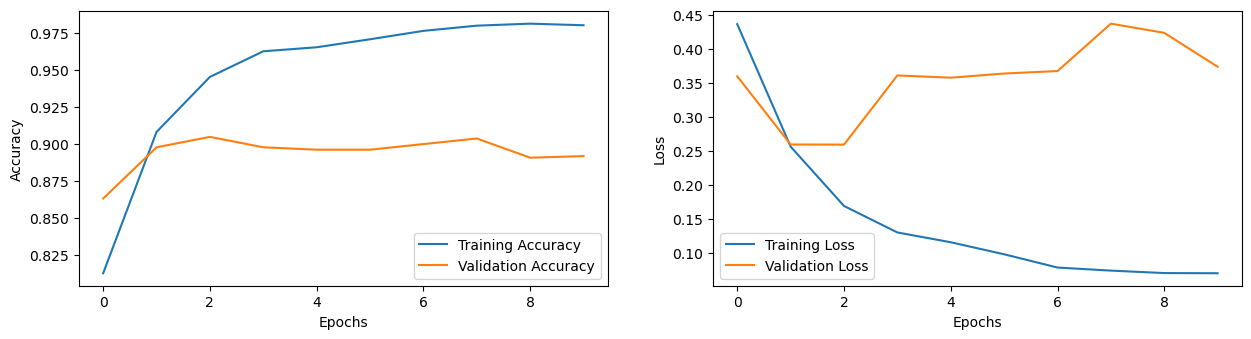

In [27]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
%matplotlib inline

# Plot the accuracy against epochs
figure(figsize=(15, 8), dpi=100)

plt.subplot(2,2,1)
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(2,2,2)

# Plot the Loss against epochs
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [28]:
loss_and_acc = model.evaluate(np.array(X_test.values.tolist()), Y_test)
print('loss = ' + str(loss_and_acc[0]))
print('accuracy = ' + str(loss_and_acc[1]))

73/73 [==============================] - 1s 13ms/step - loss: 0.3884 - accuracy: 0.8917 - auc: 0.8988
loss = 0.3883865475654602
accuracy = 0.8917280435562134


In [29]:
history = training.train_model(model, data['tokenized_text'], data['airline_sentiment'], epochs=10, batch_size=32)

Epoch 1/10
361/361 [==============================] - 31s 85ms/step - loss: 0.1945 - accuracy: 0.9430 - auc: 0.9607
Epoch 2/10
361/361 [==============================] - 32s 90ms/step - loss: 0.1580 - accuracy: 0.9498 - auc: 0.9768
Epoch 3/10
361/361 [==============================] - 31s 86ms/step - loss: 0.1561 - accuracy: 0.9500 - auc: 0.9787
Epoch 4/10
361/361 [==============================] - 34s 94ms/step - loss: 0.1704 - accuracy: 0.9459 - auc: 0.9750
Epoch 5/10
361/361 [==============================] - 34s 94ms/step - loss: 0.1891 - accuracy: 0.9376 - auc: 0.9706
Epoch 6/10
361/361 [==============================] - 32s 88ms/step - loss: 0.1978 - accuracy: 0.9338 - auc: 0.9676
Epoch 7/10
361/361 [==============================] - 30s 84ms/step - loss: 0.2076 - accuracy: 0.9302 - auc: 0.9652
Epoch 8/10
361/361 [==============================] - 32s 89ms/step - loss: 0.2458 - accuracy: 0.9189 - auc: 0.9480
Epoch 9/10
361/361 [==============================] - 34s 95ms/step - lo

In [30]:
pickle.dump(token, open(app_config.token_path, 'wb'))
model.save(app_config.model_path)

INFO:tensorflow:Assets written to: BiLSTM_Model\assets


In [31]:
from keras.models import load_model

model = load_model(app_config.model_path)
vect = pickle.load(open(app_config.token_path, 'rb'))

In [32]:
## Testing text
text = 'best trip ever'
tokenized_text = vect.texts_to_sequences([text])
padded_tokenized_text = pad_sequences(tokenized_text, 23).tolist()
index = model.predict(padded_tokenized_text)[0][0]
index

0.90334606